# OASIS toy experiments

Comparing (stochastic) gradient descent with OASIS on a few toy problems -- the first steps in the preconditioned SGD project.

OASIS implemented from Jahani et al., 2021.

https://arxiv.org/pdf/2109.05198.pdf

In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
from jax import random
from jax import jvp, grad
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from simplecryoem.optimization import sgd, oasis_adaptive
from simplecryoem.optimization import precon_sgd as oasis
from simplecryoem.optimization import conjugate_gradient as cg

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

#### Hutchinson's method

In [3]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

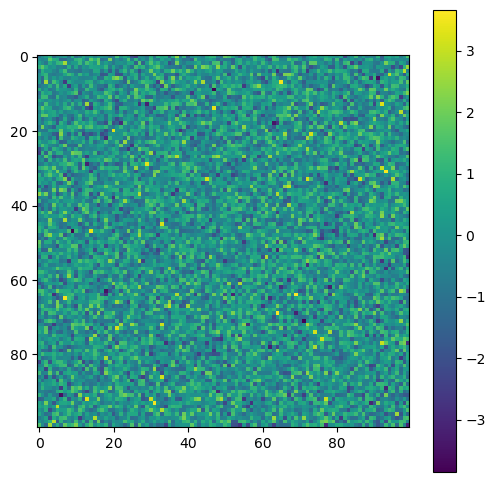

In [4]:
key, subkey = random.split(key)

A = random.normal(subkey, (n, n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A))
plt.colorbar()

In [5]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

# z * A @ z

In [6]:
zAz = jax.vmap(lambda zi: zi * (A @ zi))(z)
# plt.imshow(zAz)

In [7]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i - 1] + zAz[i]

for i in range(1, iters):
    d[i] = d[i] / (i + 1)

In [8]:
err = jnp.mean((d - jnp.diag(A)) ** 2, axis=1)

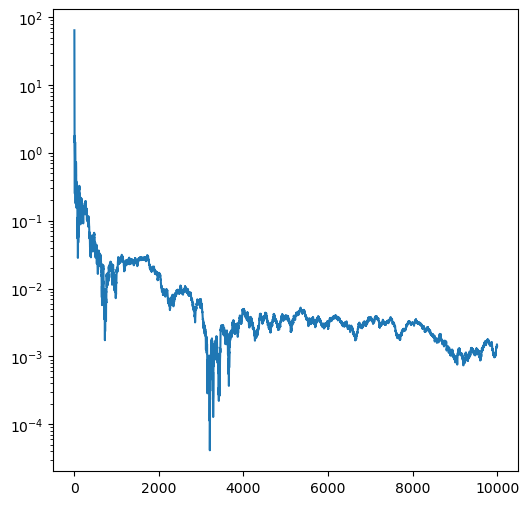

In [9]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [10]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [11]:
b = A @ x0
f = lambda x: jnp.real(jnp.mean(jnp.conj(A @ x - b) * (A @ x - b)))

In [12]:
# Naive
def hvp0(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)


# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [13]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1 - v2))

4.37 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.84 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Array(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


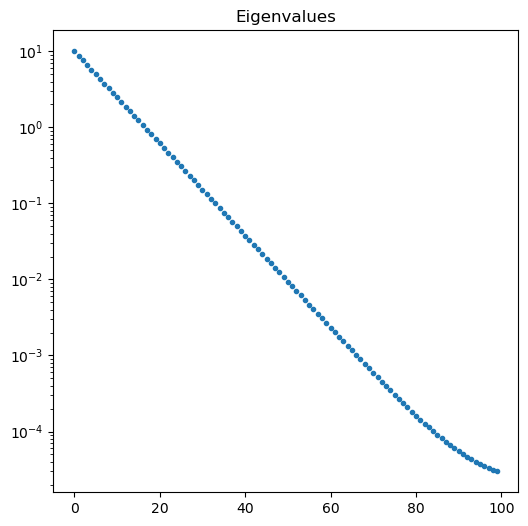

In [14]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n, n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5, 1, n))
d = d + jnp.abs(jnp.min(d) * 2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert jnp.sum(evals < 0) == 0
assert jnp.max(jnp.imag(evals)) < 1e-12
# assert(jnp.max(jnp.abs(A.T - A)) == 0)
# assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, ".")
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [15]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(
    lambda x: jnp.real(
        jnp.mean(jnp.conj(A @ x - b) * (A @ x - b)) + lam * jnp.mean(jnp.conj(x) * x)
    )
)
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
# hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v: hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
# print(f"hessianF(x_gt) = {hessianF(x_gt)}")

f(x_gt + 1) = 3.384053955556727
f(x_gt) = 1.1352388838858969
gradF(x_gt) = [-1.23288617e-02-5.62338337e-05j  2.13370393e-02-1.76956688e-03j
 -1.95778661e-02+2.35756379e-04j -5.34052707e-03-4.53540145e-04j
 -2.20518331e-02+2.00149923e-03j  6.38257861e-02-1.20228289e-03j
 -4.36431424e-02-5.36016166e-04j -5.04460066e-03+3.35408024e-04j
 -3.11196484e-02+6.80098437e-04j  2.71344565e-02+5.23989774e-04j
 -6.14111290e-02+2.93353237e-03j  3.45858046e-02-4.14993386e-04j
 -5.33069873e-02+1.54120946e-03j  3.69739229e-02+4.86418077e-04j
 -6.03809808e-03-1.27301442e-03j  2.49272499e-02-1.46467423e-03j
  4.62442929e-05-9.97074278e-04j -6.31055086e-02+3.43112168e-04j
  5.43778803e-02+1.09693377e-03j  2.86184804e-02+2.33382912e-03j
  1.15383597e-02-2.45134843e-03j -5.01783759e-03-4.82325486e-04j
 -1.71065173e-02-2.74818318e-04j  4.18536564e-02+5.07225779e-04j
 -1.08178220e-04+2.24394655e-03j -4.66307232e-03+2.72369505e-03j
  4.21975836e-02+5.03574021e-04j  6.62580321e-03+7.12554010e-04j
 -1.51127072e-0

In [16]:
def gd(F, gradF, eta, w0, N_iter=20, iter_display=1):
    loss = []
    for k in range(1, N_iter + 1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)

        w0 = w1

        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")

    return w1, jnp.array(loss)


def newton(F, gradF, hessianF, w0, N_iter=20, iter_display=1):
    loss = []
    for k in range(1, N_iter + 1):
        G = gradF(w0)
        H = hessianF(w0)

        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)

        w0 = w1

        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")

    return w1, jnp.array(loss)

In [17]:
N_iter = 1000
eta = 1e-3  # 0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display=200)

Iter 200: loss = 8.194809075187077
Iter 400: loss = 6.199178635580672
Iter 600: loss = 5.047384087203626
Iter 800: loss = 4.329131614344153
Iter 1000: loss = 3.847347921927972


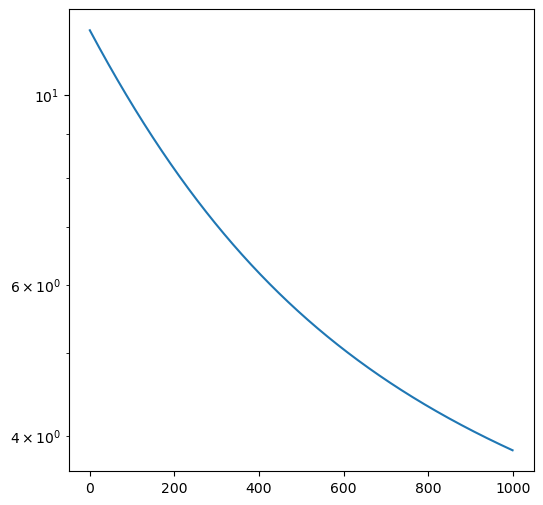

In [18]:
plt.semilogy(loss_gd)

In [19]:
# N_iter = 10

# x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [20]:
# plt.plot(loss_n)

In [21]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv: jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

  cg iter 0 ||r|| = 1.6835147872551364
  cg iter 10 ||r|| = 0.040333601661551616
  cg iter 20 ||r|| = 0.0042221310118021466
  cg iter 30 ||r|| = 0.0007597870743948283
  cg iter 40 ||r|| = 5.699358538289292e-06
  cg iter 50 ||r|| = 8.691438561081343e-07
  cg iter 60 ||r|| = 1.5236755398080094e-07
  cg iter 70 ||r|| = 2.207637207998078e-09
  cg iter 80 ||r|| = 1.7791569134868635e-10
  cg iter 90 ||r|| = 2.1857815502164194e-11
  cg iter 100 ||r|| = 5.191698925560226e-12
  cg iter 110 ||r|| = 1.5457813758336055e-12
  cg iter 120 ||r|| = 3.1812909973271364e-13
  cg iter 130 ||r|| = 1.3965493853341456e-13
  cg iter 140 ||r|| = 7.601285494928033e-14
  cg iter 150 ||r|| = 1.03645121281669e-13
  cg iter 160 ||r|| = 5.3124706130427255e-14
  cg iter 170 ||r|| = 1.2467733011051275e-14
  cg iter 180 ||r|| = 4.572486229321777e-14
  cg iter 190 ||r|| = 3.004037675066273e-14
  cg iter 200 ||r|| = 3.181578839049592e-14
  cg iter 210 ||r|| = 2.160870547574413e-14
  cg iter 220 ||r|| = 3.928859427206888e

In [22]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
# print(F(x_n))

1.1352388838858969
1.5911639644647841
3.847347921927972


#### OASIS

In [23]:
Fidx = jax.jit(lambda x, idx: F(x))
gradFidx = jax.jit(lambda x, idx: jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx: hvp(F, (x,), (v,)))

In [24]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters + 1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)

    zD0z += z * hvpFidx(x0, z, 1)

D0 = jnp.array(zD0z / iters)

# D0exact = jnp.diag(hessianF(x0)) # Cheating a bit

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6578.17it/s]


In [25]:
# plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [26]:
N_iter = 1000
beta2 = 0.99
eta = 0.1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0.1  # 0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o, _, _ = oasis(
    subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display=100
)

Epoch 100/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 461.01it/s, eta=1.000e-01, loss=1.684e+00]


  Loss =  1.68374249e+00
  eta = 0.1
  alpha= 0.1
Epoch 200/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 629.68it/s, eta=1.000e-01, loss=1.644e+00]

  Loss =  1.64403554e+00
  eta = 0.1
  alpha= 0.1


Epoch 300/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 659.59it/s, eta=1.000e-01, loss=1.626e+00]


  Loss =  1.62577270e+00
  eta = 0.1
  alpha= 0.1
Epoch 400/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 657.93it/s, eta=1.000e-01, loss=1.615e+00]

  Loss =  1.61488027e+00
  eta = 0.1
  alpha= 0.1


Epoch 500/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 712.23it/s, eta=1.000e-01, loss=1.608e+00]

  Loss =  1.60773320e+00
  eta = 0.1
  alpha= 0.1


Epoch 600/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 570.73it/s, eta=1.000e-01, loss=1.603e+00]

  Loss =  1.60286647e+00
  eta = 0.1
  alpha= 0.1


Epoch 700/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 712.23it/s, eta=1.000e-01, loss=1.600e+00]

  Loss =  1.59950517e+00
  eta = 0.1
  alpha= 0.1


Epoch 800/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 670.98it/s, eta=1.000e-01, loss=1.597e+00]

  Loss =  1.59715546e+00
  eta = 0.1
  alpha= 0.1


Epoch 900/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 588.51it/s, eta=1.000e-01, loss=1.595e+00]

  Loss =  1.59549977e+00
  eta = 0.1
  alpha= 0.1


Epoch 1000/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 724.15it/s, eta=1.000e-01, loss=1.594e+00]

  Loss =  1.59432243e+00
  eta = 0.1
  alpha= 0.1


In [27]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1  # 0.1/0.001/0.01/0.15

alpha = 0.1  # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta0,
    D0,
    beta2,
    alpha,
    N_iter,
    iter_display=500,
)

Epoch 500/1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 451.10it/s, loss=1.593e+00]

  Loss =  1.593e+00


Epoch 1000/1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 400.79it/s, loss=1.591e+00]

  Loss =  1.591e+00


0.9436868407182726
1.1452012582777398
0.9338427868414518
0.9416597603967256


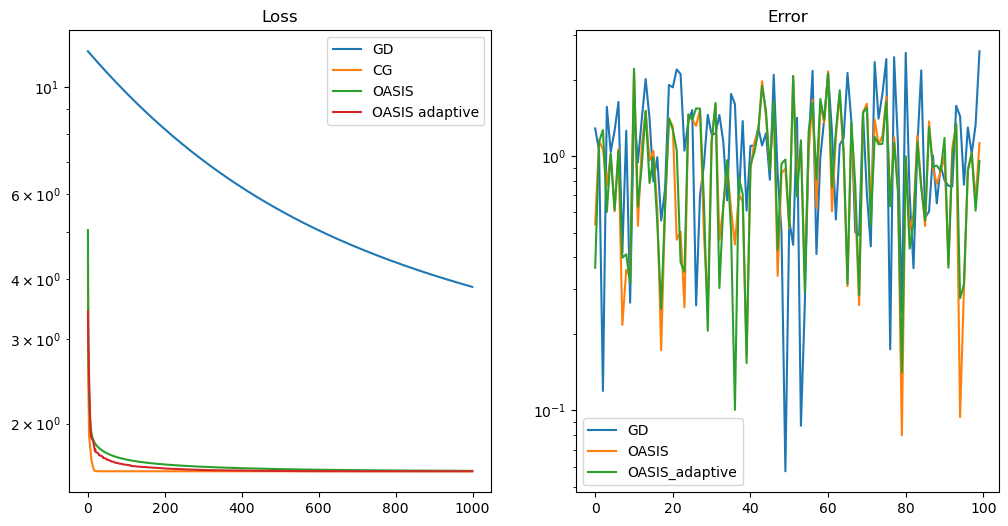

In [28]:
# print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt - x_cg)))
print(jnp.mean(jnp.abs(x_gt - x_gd)))
print(jnp.mean(jnp.abs(x_gt - x_o)))
print(jnp.mean(jnp.abs(x_gt - x_oa)))

plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)

nn0 = 0
nn1 = 1000
# plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
# plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1, 2, 2)
# plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt - x_gd))
plt.semilogy(jnp.abs(x_gt - x_o))
plt.semilogy(jnp.abs(x_gt - x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"] = 6, 6

### Stochastic - sum of operators

In [29]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [30]:
sig_noise = 10
lam = 0.1

In [31]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)

    A = random.normal(subkeys[0], (n, n), dtype=x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)

    d = jnp.logspace(10, -5, n) + random.normal(subkeys[1], (n,), dtype=jnp.double) * 10
    d = d + jnp.abs(jnp.min(d) * 2)

    A = v.T @ jnp.diag(d) @ v
    ops.append(A)

    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype=x_gt.dtype) * sig_noise
    b.append(bn)

    # print(jnp.mean((A@x_gt - bn)**2))

ops = jnp.array(ops)
b = jnp.array(b)

In [32]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 4.10e+08


In [33]:
print(jnp.max(w))
print(jnp.min(w))

10000000046.66665
24.388661091181007


In [34]:
def loss_term(x, A, b):
    return (
        1
        / 2
        * jnp.real(
            jnp.mean(jnp.conj(A @ x - b) * (A @ x - b))
            + lam * jnp.mean(jnp.conj(x) * x)
        )
    )


def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes=(None, 0, 0))(x, ops, b))


def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)


def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y: grad_loss_func(y, ops, b), (x,), (v,))[1]

In [35]:
idx = np.random.permutation(N)[: N // 3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

48.87290077385235
49.84344209662335
(100,)
(100,)
(100,)
(100,)


In [36]:
key, subkey = random.split(key)

hessianF = lambda x: jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx: loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx: grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx: hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype=x_gt.dtype)

In [37]:
Fidx(x_gt, jnp.arange(N))

Array(49.8434421, dtype=float64)

In [38]:
# D0 = jnp.ones((nx,nx,nx))  #<--- not very good
# D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2 * iters + 1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2 * i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2 * i + 1], N)[:batch_sz]

    zD0z += z * hvpFidx(x0, z, idx)

D0 = jnp.array(zD0z / iters)


# plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 512.81it/s]


In [39]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os, _, _ = oasis(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=20,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.55it/s, eta=1.000e-01, loss=1.165e+15]


  Loss =  1.25263108e+15
  eta = 0.1
  alpha= 0
Epoch 2/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 250.99it/s, eta=1.000e-01, loss=2.659e+12]


  Loss =  3.38543883e+12
  eta = 0.1
  alpha= 0
Epoch 3/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 251.03it/s, eta=1.000e-01, loss=1.569e+10]


  Loss =  1.47746553e+10
  eta = 0.1
  alpha= 0
Epoch 4/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 254.84it/s, eta=1.000e-01, loss=6.902e+07]


  Loss =  6.39595876e+07
  eta = 0.1
  alpha= 0
Epoch 5/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 249.36it/s, eta=1.000e-01, loss=2.290e+05]


  Loss =  3.09546226e+05
  eta = 0.1
  alpha= 0
Epoch 6/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 255.17it/s, eta=1.000e-01, loss=8.689e+02]


  Loss =  1.19729812e+03
  eta = 0.1
  alpha= 0
Epoch 7/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 252.52it/s, eta=1.000e-01, loss=5.069e+01]


  Loss =  5.48809162e+01
  eta = 0.1
  alpha= 0
Epoch 8/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 257.62it/s, eta=1.000e-01, loss=5.092e+01]


  Loss =  4.99884325e+01
  eta = 0.1
  alpha= 0
Epoch 9/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 258.44it/s, eta=1.000e-01, loss=5.053e+01]


  Loss =  4.99022038e+01
  eta = 0.1
  alpha= 0
Epoch 10/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 261.83it/s, eta=1.000e-01, loss=4.972e+01]


  Loss =  4.99801370e+01
  eta = 0.1
  alpha= 0
Epoch 11/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 258.49it/s, eta=1.000e-01, loss=4.902e+01]


  Loss =  4.99491489e+01
  eta = 0.1
  alpha= 0
Epoch 12/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 263.88it/s, eta=1.000e-01, loss=4.945e+01]


  Loss =  4.98807329e+01
  eta = 0.1
  alpha= 0
Epoch 13/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 263.15it/s, eta=1.000e-01, loss=5.223e+01]


  Loss =  4.99456322e+01
  eta = 0.1
  alpha= 0
Epoch 14/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 259.16it/s, eta=1.000e-01, loss=5.187e+01]


  Loss =  4.99250470e+01
  eta = 0.1
  alpha= 0
Epoch 15/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 259.90it/s, eta=1.000e-01, loss=4.866e+01]


  Loss =  4.99703236e+01
  eta = 0.1
  alpha= 0
Epoch 16/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.53it/s, eta=1.000e-01, loss=4.873e+01]


  Loss =  4.99466888e+01
  eta = 0.1
  alpha= 0
Epoch 17/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 259.45it/s, eta=1.000e-01, loss=4.760e+01]


  Loss =  4.99177371e+01
  eta = 0.1
  alpha= 0
Epoch 18/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 259.00it/s, eta=1.000e-01, loss=5.122e+01]


  Loss =  4.99026827e+01
  eta = 0.1
  alpha= 0
Epoch 19/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 259.34it/s, eta=1.000e-01, loss=4.917e+01]


  Loss =  5.01048718e+01
  eta = 0.1
  alpha= 0
Epoch 20/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 257.52it/s, eta=1.000e-01, loss=4.844e+01]


  Loss =  5.01970349e+01
  eta = 0.1
  alpha= 0


In [40]:
N_epoch = 20
beta2 = 0.99
eta = 0.01  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=20,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.18it/s, loss=9.967e+15]


  Loss =  1.191e+16
Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 216.18it/s, loss=1.038e+14]


  Loss =  1.088e+14
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.65it/s, loss=2.818e+12]


  Loss =  3.025e+12
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 216.10it/s, loss=5.354e+10]


  Loss =  7.588e+10
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.21it/s, loss=2.216e+09]


  Loss =  2.473e+09
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 217.62it/s, loss=8.887e+07]


  Loss =  7.562e+07
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 222.13it/s, loss=1.388e+06]


  Loss =  1.784e+06
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.38it/s, loss=2.484e+04]


  Loss =  3.109e+04
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 217.73it/s, loss=2.897e+02]


  Loss =  3.029e+02
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.03it/s, loss=5.134e+01]


  Loss =  5.206e+01
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 220.08it/s, loss=4.919e+01]


  Loss =  5.028e+01
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 216.44it/s, loss=5.039e+01]


  Loss =  4.986e+01
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 220.66it/s, loss=4.743e+01]


  Loss =  4.988e+01
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 219.85it/s, loss=4.928e+01]


  Loss =  4.986e+01
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 221.53it/s, loss=4.661e+01]


  Loss =  4.990e+01
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 222.65it/s, loss=4.989e+01]


  Loss =  4.987e+01
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 219.25it/s, loss=5.088e+01]


  Loss =  4.991e+01
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 218.91it/s, loss=4.891e+01]


  Loss =  4.990e+01
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 220.06it/s, loss=5.118e+01]


  Loss =  4.996e+01
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 220.73it/s, loss=4.912e+01]


  Loss =  4.990e+01


In [41]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o, _, _ = oasis(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=None,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it, eta=1.000e-01, loss=1.903e+18]


  Loss =  1.90302112e+18
  eta = 0.1
  alpha= 0
Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s, eta=1.000e-01, loss=1.511e+18]


  Loss =  1.51082335e+18
  eta = 0.1
  alpha= 0
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s, eta=1.000e-01, loss=1.240e+18]


  Loss =  1.24006332e+18
  eta = 0.1
  alpha= 0
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s, eta=1.000e-01, loss=1.031e+18]


  Loss =  1.03114105e+18
  eta = 0.1
  alpha= 0
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s, eta=1.000e-01, loss=8.626e+17]


  Loss =  8.62604447e+17
  eta = 0.1
  alpha= 0
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s, eta=1.000e-01, loss=7.242e+17]


  Loss =  7.24206825e+17
  eta = 0.1
  alpha= 0
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s, eta=1.000e-01, loss=6.096e+17]


  Loss =  6.09649149e+17
  eta = 0.1
  alpha= 0
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s, eta=1.000e-01, loss=5.144e+17]


  Loss =  5.14402282e+17
  eta = 0.1
  alpha= 0
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s, eta=1.000e-01, loss=4.350e+17]


  Loss =  4.34972496e+17
  eta = 0.1
  alpha= 0
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s, eta=1.000e-01, loss=3.686e+17]


  Loss =  3.68559798e+17
  eta = 0.1
  alpha= 0
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s, eta=1.000e-01, loss=3.129e+17]


  Loss =  3.12901378e+17
  eta = 0.1
  alpha= 0
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s, eta=1.000e-01, loss=2.661e+17]


  Loss =  2.66141126e+17
  eta = 0.1
  alpha= 0
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.80it/s, eta=1.000e-01, loss=2.268e+17]


  Loss =  2.26775723e+17
  eta = 0.1
  alpha= 0
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s, eta=1.000e-01, loss=1.936e+17]


  Loss =  1.93572378e+17
  eta = 0.1
  alpha= 0
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s, eta=1.000e-01, loss=1.655e+17]


  Loss =  1.65507735e+17
  eta = 0.1
  alpha= 0
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s, eta=1.000e-01, loss=1.417e+17]


  Loss =  1.41736845e+17
  eta = 0.1
  alpha= 0
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s, eta=1.000e-01, loss=1.216e+17]


  Loss =  1.21563959e+17
  eta = 0.1
  alpha= 0
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s, eta=1.000e-01, loss=1.044e+17]


  Loss =  1.04416709e+17
  eta = 0.1
  alpha= 0
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s, eta=1.000e-01, loss=8.982e+16]


  Loss =  8.98162754e+16
  eta = 0.1
  alpha= 0
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s, eta=1.000e-01, loss=7.736e+16]

  Loss =  7.73622604e+16
  eta = 0.1
  alpha= 0


In [42]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=None,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=1.695e+18]


  Loss =  1.695e+18
Epoch 2/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=1.533e+18]


  Loss =  1.533e+18
Epoch 3/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=1.337e+18]


  Loss =  1.337e+18
Epoch 4/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=1.083e+18]


  Loss =  1.083e+18
Epoch 5/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s, loss=7.739e+17]


  Loss =  7.739e+17
Epoch 6/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s, loss=4.458e+17]


  Loss =  4.458e+17
Epoch 7/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s, loss=1.791e+17]


  Loss =  1.791e+17
Epoch 8/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=1.528e+17]


  Loss =  1.528e+17
Epoch 9/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s, loss=7.569e+16]


  Loss =  7.569e+16
Epoch 10/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=7.182e+16]


  Loss =  7.182e+16
Epoch 11/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=6.756e+16]


  Loss =  6.756e+16
Epoch 12/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s, loss=6.171e+16]


  Loss =  6.171e+16
Epoch 13/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s, loss=5.345e+16]


  Loss =  5.345e+16
Epoch 14/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s, loss=4.229e+16]


  Loss =  4.229e+16
Epoch 15/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s, loss=2.872e+16]


  Loss =  2.872e+16
Epoch 16/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s, loss=1.494e+16]


  Loss =  1.494e+16
Epoch 17/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s, loss=5.058e+15]


  Loss =  5.058e+15
Epoch 18/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s, loss=9.415e+15]


  Loss =  9.415e+15
Epoch 19/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s, loss=3.474e+15]


  Loss =  3.474e+15
Epoch 20/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s, loss=2.721e+15]

  Loss =  2.721e+15


In [43]:
N_epoch = 20
eta = 1e-18

key, subkey = random.split(key)
x_sgd, loss_sgd, _, _, _ = sgd(
    key,
    gradFidx,
    Fidx,
    N,
    x0,
    eta,
    N_epoch,
    batch_size=20,
    verbose=True,
    iter_display=1,
)

Epoch 1/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.35it/s, eta=1.000e-18, grad=4.246e+16, loss=3.646e+17]


  |Grad| = 7.443e+16
  Loss = 3.85000879e+17
  eta = 1e-18
  alpha = 1e-10
Epoch 2/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 578.60it/s, eta=1.000e-18, grad=1.535e+16, loss=6.927e+16]


  |Grad| = 2.966e+16
  Loss = 8.09840484e+16
  eta = 1e-18
  alpha = 1e-10
Epoch 3/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 578.89it/s, eta=1.000e-18, grad=1.263e+16, loss=1.915e+16]


  |Grad| = 1.417e+16
  Loss = 1.90652230e+16
  eta = 1e-18
  alpha = 1e-10
Epoch 4/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 565.01it/s, eta=1.000e-18, grad=4.514e+15, loss=5.238e+15]


  |Grad| = 6.887e+15
  Loss = 4.84601426e+15
  eta = 1e-18
  alpha = 1e-10
Epoch 5/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 550.47it/s, eta=1.000e-18, grad=2.380e+15, loss=1.388e+15]


  |Grad| = 3.600e+15
  Loss = 1.29035300e+15
  eta = 1e-18
  alpha = 1e-10
Epoch 6/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 552.95it/s, eta=1.000e-18, grad=1.729e+15, loss=4.457e+14]


  |Grad| = 1.845e+15
  Loss = 3.57301503e+14
  eta = 1e-18
  alpha = 1e-10
Epoch 7/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 571.19it/s, eta=1.000e-18, grad=8.402e+14, loss=1.135e+14]


  |Grad| = 9.746e+14
  Loss = 1.01525229e+14
  eta = 1e-18
  alpha = 1e-10
Epoch 8/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 556.21it/s, eta=1.000e-18, grad=3.630e+14, loss=2.654e+13]


  |Grad| = 4.908e+14
  Loss = 2.93127274e+13
  eta = 1e-18
  alpha = 1e-10
Epoch 9/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.14it/s, eta=1.000e-18, grad=1.569e+14, loss=7.173e+12]


  |Grad| = 2.680e+14
  Loss = 8.63954034e+12
  eta = 1e-18
  alpha = 1e-10
Epoch 10/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 556.78it/s, eta=1.000e-18, grad=8.978e+13, loss=2.508e+12]


  |Grad| = 1.493e+14
  Loss = 2.58853061e+12
  eta = 1e-18
  alpha = 1e-10
Epoch 11/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 562.17it/s, eta=1.000e-18, grad=5.672e+13, loss=7.676e+11]


  |Grad| = 7.642e+13
  Loss = 7.80844206e+11
  eta = 1e-18
  alpha = 1e-10
Epoch 12/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 560.58it/s, eta=1.000e-18, grad=3.039e+13, loss=2.490e+11]


  |Grad| = 4.429e+13
  Loss = 2.39373105e+11
  eta = 1e-18
  alpha = 1e-10
Epoch 13/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.53it/s, eta=1.000e-18, grad=1.894e+13, loss=8.114e+10]


  |Grad| = 2.481e+13
  Loss = 7.38301655e+10
  eta = 1e-18
  alpha = 1e-10
Epoch 14/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.73it/s, eta=1.000e-18, grad=9.892e+12, loss=2.209e+10]


  |Grad| = 1.368e+13
  Loss = 2.30848478e+10
  eta = 1e-18
  alpha = 1e-10
Epoch 15/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 538.91it/s, eta=1.000e-18, grad=6.319e+12, loss=7.641e+09]


  |Grad| = 7.507e+12
  Loss = 7.19810267e+09
  eta = 1e-18
  alpha = 1e-10
Epoch 16/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 563.64it/s, eta=1.000e-18, grad=2.733e+12, loss=1.621e+09]


  |Grad| = 4.160e+12
  Loss = 2.27942237e+09
  eta = 1e-18
  alpha = 1e-10
Epoch 17/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 560.75it/s, eta=1.000e-18, grad=1.887e+12, loss=6.528e+08]


  |Grad| = 2.396e+12
  Loss = 7.24796992e+08
  eta = 1e-18
  alpha = 1e-10
Epoch 18/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 565.05it/s, eta=1.000e-18, grad=1.130e+12, loss=2.322e+08]


  |Grad| = 1.353e+12
  Loss = 2.32017638e+08
  eta = 1e-18
  alpha = 1e-10
Epoch 19/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 548.17it/s, eta=1.000e-18, grad=5.498e+11, loss=7.733e+07]


  |Grad| = 7.647e+11
  Loss = 7.43965999e+07
  eta = 1e-18
  alpha = 1e-10
Epoch 20/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.40it/s, eta=1.000e-18, grad=3.041e+11, loss=2.048e+07]


  |Grad| = 4.299e+11
  Loss = 2.40278811e+07
  eta = 1e-18
  alpha = 1e-10


In [44]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1

key, subkey = random.split(key)
x_sgdp, loss_sgdp, _, _, _ = sgd(
    key,
    gradFidx,
    Fidx,
    N,
    x0,
    eta,
    N_epoch,
    batch_size=20,
    D0=D0,
    verbose=True,
    iter_display=1,
)

Epoch 1/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 564.74it/s, eta=1.000e-01, grad=2.552e+15, loss=7.626e+14]


  |Grad| = 3.197e+16
  Loss = 9.66916510e+14
  eta = 0.1
  alpha = 1e-10
Epoch 2/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 557.03it/s, eta=1.000e-01, grad=8.217e+13, loss=1.360e+12]


  |Grad| = 7.374e+14
  Loss = 1.57238562e+12
  eta = 0.1
  alpha = 1e-10
Epoch 3/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 557.03it/s, eta=1.000e-01, grad=5.529e+12, loss=3.269e+09]


  |Grad| = 3.077e+13
  Loss = 3.45016776e+09
  eta = 0.1
  alpha = 1e-10
Epoch 4/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 563.86it/s, eta=1.000e-01, grad=3.068e+11, loss=1.055e+07]


  |Grad| = 1.460e+12
  Loss = 9.82942572e+06
  eta = 0.1
  alpha = 1e-10
Epoch 5/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 559.67it/s, eta=1.000e-01, grad=1.710e+10, loss=2.839e+04]


  |Grad| = 7.793e+10
  Loss = 3.01047989e+04
  eta = 0.1
  alpha = 1e-10
Epoch 6/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 566.31it/s, eta=1.000e-01, grad=6.554e+08, loss=1.243e+02]


  |Grad| = 4.496e+09
  Loss = 1.46771767e+02
  eta = 0.1
  alpha = 1e-10
Epoch 7/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.25it/s, eta=1.000e-01, grad=8.821e+07, loss=5.124e+01]


  |Grad| = 2.796e+08
  Loss = 5.02496788e+01
  eta = 0.1
  alpha = 1e-10
Epoch 8/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 556.99it/s, eta=1.000e-01, grad=6.796e+07, loss=5.008e+01]


  |Grad| = 8.595e+07
  Loss = 4.99031116e+01
  eta = 0.1
  alpha = 1e-10
Epoch 9/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 556.41it/s, eta=1.000e-01, grad=8.246e+07, loss=4.897e+01]


  |Grad| = 8.542e+07
  Loss = 4.99906937e+01
  eta = 0.1
  alpha = 1e-10
Epoch 10/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 578.13it/s, eta=1.000e-01, grad=6.794e+07, loss=4.945e+01]


  |Grad| = 8.812e+07
  Loss = 4.98765593e+01
  eta = 0.1
  alpha = 1e-10
Epoch 11/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 557.90it/s, eta=1.000e-01, grad=9.111e+07, loss=4.810e+01]


  |Grad| = 8.531e+07
  Loss = 4.99091399e+01
  eta = 0.1
  alpha = 1e-10
Epoch 12/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 542.13it/s, eta=1.000e-01, grad=7.921e+07, loss=5.180e+01]


  |Grad| = 8.875e+07
  Loss = 4.99966766e+01
  eta = 0.1
  alpha = 1e-10
Epoch 13/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 563.18it/s, eta=1.000e-01, grad=6.687e+07, loss=4.958e+01]


  |Grad| = 8.861e+07
  Loss = 4.99231185e+01
  eta = 0.1
  alpha = 1e-10
Epoch 14/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 564.56it/s, eta=1.000e-01, grad=7.285e+07, loss=4.808e+01]


  |Grad| = 7.935e+07
  Loss = 4.98898702e+01
  eta = 0.1
  alpha = 1e-10
Epoch 15/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 580.23it/s, eta=1.000e-01, grad=1.039e+08, loss=5.132e+01]


  |Grad| = 8.701e+07
  Loss = 4.99287828e+01
  eta = 0.1
  alpha = 1e-10
Epoch 16/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 564.86it/s, eta=1.000e-01, grad=5.949e+07, loss=4.875e+01]


  |Grad| = 8.286e+07
  Loss = 4.99065881e+01
  eta = 0.1
  alpha = 1e-10
Epoch 17/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.46it/s, eta=1.000e-01, grad=8.568e+07, loss=5.206e+01]


  |Grad| = 8.720e+07
  Loss = 4.99199948e+01
  eta = 0.1
  alpha = 1e-10
Epoch 18/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 563.65it/s, eta=1.000e-01, grad=6.915e+07, loss=4.890e+01]


  |Grad| = 9.000e+07
  Loss = 4.99078924e+01
  eta = 0.1
  alpha = 1e-10
Epoch 19/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.15it/s, eta=1.000e-01, grad=1.017e+08, loss=4.829e+01]


  |Grad| = 8.148e+07
  Loss = 4.99868215e+01
  eta = 0.1
  alpha = 1e-10
Epoch 20/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 546.12it/s, eta=1.000e-01, grad=9.133e+07, loss=4.951e+01]


  |Grad| = 9.010e+07
  Loss = 4.99051741e+01
  eta = 0.1
  alpha = 1e-10


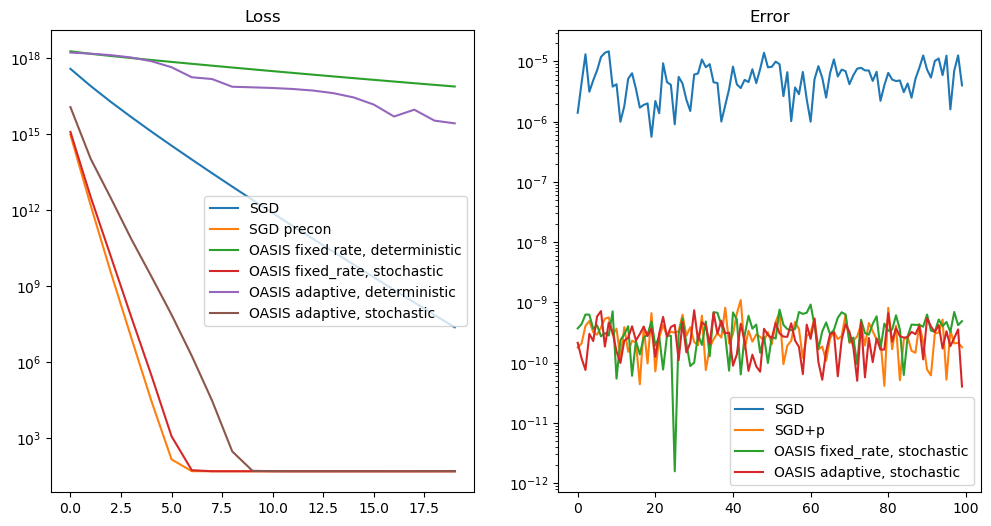

In [45]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(
    [
        "SGD",
        "SGD precon",
        "OASIS fixed rate, deterministic",
        "OASIS fixed_rate, stochastic",
        "OASIS adaptive, deterministic",
        "OASIS adaptive, stochastic",
    ]
)
# plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.semilogy(jnp.abs(x_sgd - x_gt))
plt.semilogy(jnp.abs(x_sgdp - x_gt))
# plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os - x_gt))
# plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa - x_gt))
# plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(
    ["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"]
)
plt.title("Error")

plt.rcParams["figure.figsize"] = 6, 6

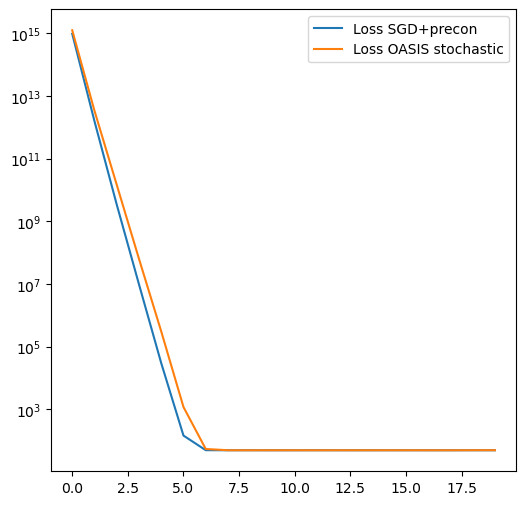

In [46]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [47]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))

49.84344209662335
24027881.07841546
49.90517411799556
7.736226039738427e+16
50.19703489254767
2720744253843794.5
49.897777275800586
